In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("data/NSEI.csv", index_col=0, parse_dates=True)
df.tail()

C:\Users\light\AppData\Local\Temp\ipykernel_11812\1963863574.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv("data/NSEI.csv", index_col=0, parse_dates=True)


,Close,High,Low,Open,Volume
Price,,,,,
2025-11-12,25875.80078125,25934.55078125,25781.150390625,25834.30078125,312600
2025-11-13,25879.150390625,26010.69921875,25808.400390625,25906.099609375,385200
2025-11-14,25910.05078125,25940.19921875,25740.80078125,25767.900390625,518900
2025-11-17,26013.44921875,26024.19921875,25906.349609375,25948.19921875,281800
2025-11-18,25910.05078125,26029.849609375,25876.5,26021.80078125,280000


In [4]:
df = df[['Open','High','Low','Close','Volume']].copy()
df.head()

,Open,High,Low,Close,Volume
Price,,,,,
Ticker,^NSEI,^NSEI,^NSEI,^NSEI,^NSEI
Date,NaN,NaN,NaN,NaN,NaN
2013-01-02,5982.60009765625,6006.0498046875,5982.0,5993.25,0
2013-01-03,6015.7998046875,6017.0,5986.5498046875,6009.5,0
2013-01-04,6011.9501953125,6020.75,5981.5498046875,6016.14990234375,0


In [10]:
# 1. coerce index to datetimes and drop non-datetime rows
import pandas as pd, numpy as np

# show the first 10 index values again (for context)
print("Before cleaning — first 12 index entries:\n", df.index[:12])

# coerce to datetime; non-parsable entries become NaT
idx = pd.to_datetime(df.index, errors='coerce')

# find non-datetime rows
bad_mask = idx.isna()
print("\nNon-datetime rows count:", bad_mask.sum())
if bad_mask.any():
    print("\nRows that will be dropped (first 10 shown):\n", df[bad_mask].head(10))

# drop those rows and reassign cleaned datetime index
df = df[~bad_mask].copy()
df.index = pd.to_datetime(df.index)
df.index.name = 'Date'    # give a clean name to the index

# quick check
print("\nAfter cleaning — index range:", df.index.min(), "->", df.index.max())
print("Sample rows:\n", df.head(3))

Before cleaning — first 12 index entries:
 DatetimeIndex(['2013-01-30', '2013-01-31', '2013-02-01', '2013-02-04',
               '2013-02-05', '2013-02-06', '2013-02-07', '2013-02-08',
               '2013-02-11', '2013-02-12', '2013-02-13', '2013-02-14'],
              dtype='datetime64[ns]', name='Price', freq=None)

Non-datetime rows count: 0

After cleaning — index range: 2013-01-30 00:00:00 -> 2025-11-18 00:00:00
Sample rows:
                    Open         High          Low        Close    Volume  \
Date                                                                       
2013-01-30  6065.000000  6071.950195  6044.149902  6055.750000  124200.0   
2013-01-31  6045.649902  6058.049805  6025.149902  6034.750000  168500.0   
2013-02-01  6040.950195  6052.950195  5983.200195  5998.899902  159300.0   

              logret     ret_5    vol_20    mom_20  
Date                                                
2013-01-30  0.000967  0.000240  0.085734  0.010428  
2013-01-31 -0.003474  0.

In [11]:
# 2. make sure numeric columns are numeric, then create features
df = df[['Open','High','Low','Close','Volume']].astype(float).copy()

df['logret'] = np.log(df['Close'] / df['Close'].shift(1))
df['ret_5'] = df['Close'].pct_change(5)
df['vol_20'] = df['logret'].rolling(20).std() * np.sqrt(252)
df['mom_20'] = df['Close'] / df['Close'].shift(20) - 1

df = df.dropna().copy()
display(df[['logret','vol_20','mom_20']].describe().round(6))

,logret,vol_20,mom_20
count,3125.000000,3125.000000,3125.000000
mean,0.000481,0.143457,0.010550
std,0.010319,0.078894,0.045646
min,-0.139038,0.050175,-0.370057
25%,-0.004339,0.099438,-0.014416
50%,0.000693,0.127535,0.011960
75%,0.005980,0.161411,0.038794
max,0.084003,0.904851,0.202904


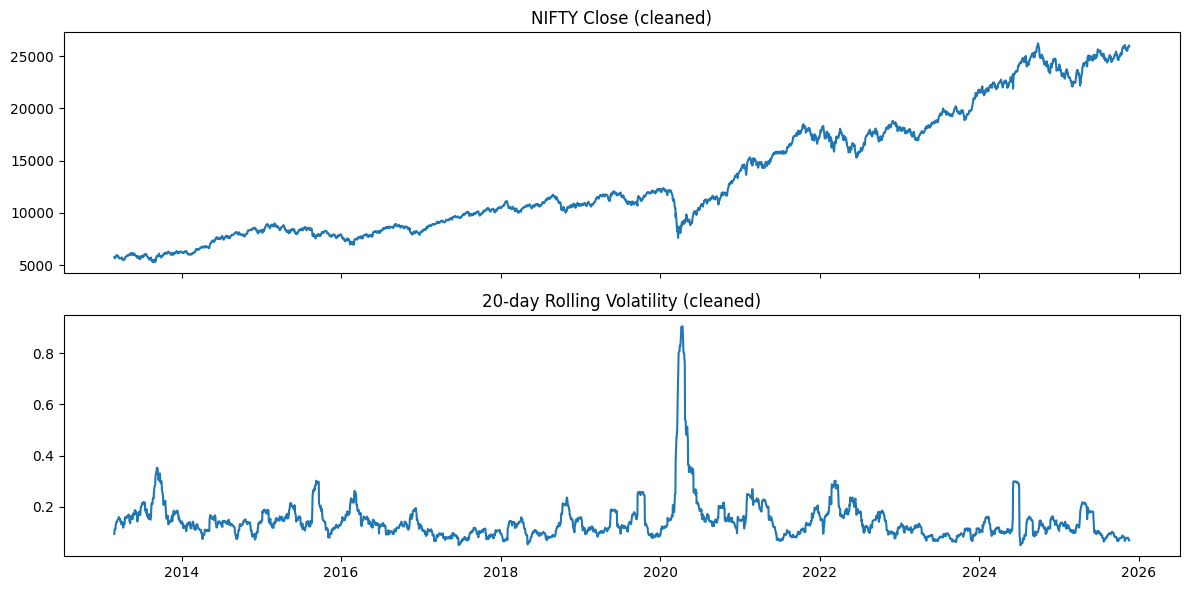

In [12]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2,1, figsize=(12,6), sharex=True)
ax[0].plot(df.index, df['Close'])
ax[0].set_title("NIFTY Close (cleaned)")

ax[1].plot(df.index, df['vol_20'])
ax[1].set_title("20-day Rolling Volatility (cleaned)")

plt.tight_layout()
plt.show()

In [14]:
# STEP 5.1: KMeans baseline
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

features = df[['logret','vol_20','mom_20']].copy()
scaler = StandardScaler()
X = scaler.fit_transform(features)

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
labels = kmeans.fit_predict(X)
df['cluster_kmeans'] = labels

# counts and centroid info
print("Cluster counts:\n", df['cluster_kmeans'].value_counts().sort_index())
centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), 
                         columns=features.columns)
centroids.index = [f'cluster_{i}' for i in centroids.index]
print("\nCluster centroids (in original feature scale):\n", centroids.round(6))


Cluster counts:
 cluster_kmeans
0    1869
1    1229
2      27
Name: count, dtype: int64

Cluster centroids (in original feature scale):
              logret    vol_20    mom_20
cluster_0  0.004199  0.131249  0.034558
cluster_1 -0.005060  0.149226 -0.021676
cluster_2 -0.004293  0.725241 -0.182372


In [15]:
# STEP 5.2: per-cluster stats
cluster_stats = df.groupby('cluster_kmeans')[['logret','vol_20','mom_20']].agg(['mean','std','median'])
display(cluster_stats.round(6))


logret                        vol_20                      \
                    mean       std    median      mean       std    median   
cluster_kmeans                                                               
0               0.004197  0.007249  0.003564  0.131235  0.055614  0.117149   
1              -0.005065  0.009259 -0.004339  0.149261  0.053321  0.137955   
2              -0.004293  0.050002 -0.000529  0.725241  0.165999  0.797779   

                  mom_20                      
                    mean       std    median  
cluster_kmeans                                
0               0.034539  0.029740  0.032446  
1              -0.021694  0.028868 -0.019340  
2              -0.182372  0.135205 -0.227707

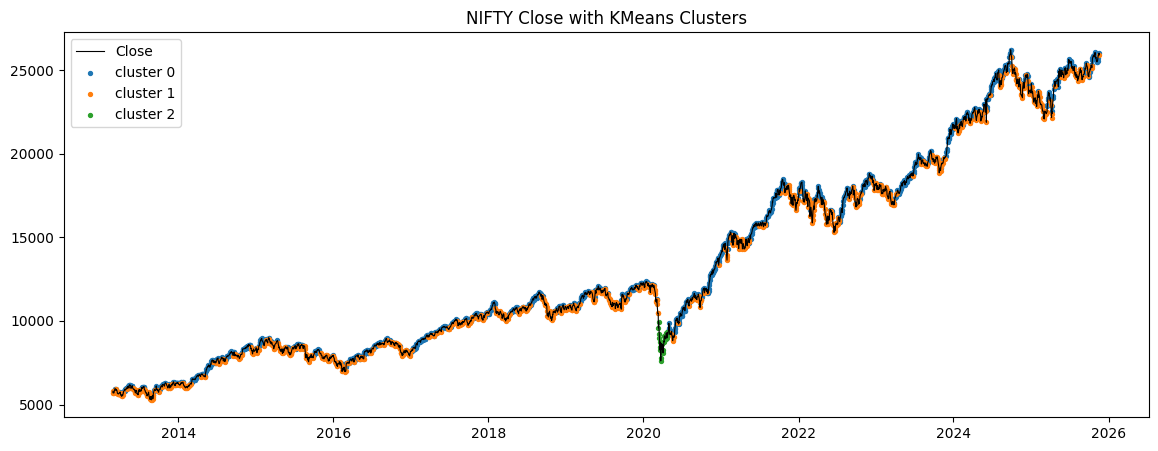

In [16]:
# STEP 5.3: plot clusters on price timeline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(14,5))
ax.plot(df.index, df['Close'], color='black', lw=0.8, label='Close')

unique_clusters = sorted(df['cluster_kmeans'].unique())
cmap = plt.get_cmap('tab10')

for i, c in enumerate(unique_clusters):
    idx = df[df['cluster_kmeans'] == c].index
    ax.scatter(idx, df.loc[idx, 'Close'], s=8, color=cmap(i), label=f'cluster {c}')

ax.legend()
ax.set_title("NIFTY Close with KMeans Clusters")
plt.show()

In [17]:
print(df.groupby('cluster_kmeans')['vol_20'].describe().round(4))

                 count    mean     std     min     25%     50%     75%     max
cluster_kmeans                                                                
0               1869.0  0.1312  0.0556  0.0502  0.0938  0.1171  0.1519  0.5385
1               1229.0  0.1493  0.0533  0.0509  0.1147  0.1380  0.1745  0.5130
2                 27.0  0.7252  0.1660  0.3734  0.6265  0.7978  0.8290  0.9049


In [18]:
# STEP 6.1: Prepare data for HMM
from sklearn.preprocessing import StandardScaler
from hmmlearn.hmm import GaussianHMM

# Use the same features as before
features = df[['logret', 'vol_20', 'mom_20']].copy()

# Scale features
scaler_hmm = StandardScaler()
X_hmm = scaler_hmm.fit_transform(features)

print("Shape of HMM dataset:", X_hmm.shape)

Shape of HMM dataset: (3125, 3)


In [19]:
# STEP 6.2: Train the HMM model
from hmmlearn.hmm import GaussianHMM

hmm_model = GaussianHMM(
    n_components=3,
    covariance_type='full',
    n_iter=200,
    random_state=42
)

hmm_model.fit(X_hmm)

print("Converged:", hmm_model.monitor_.converged)
print("Iterations used:", hmm_model.monitor_.iter)

Converged: True
Iterations used: 125


In [20]:
# STEP 6.3: Predict hidden states
hmm_states = hmm_model.predict(X_hmm)
df['state_hmm'] = hmm_states

# show first rows with state
display(df[['Close','logret','vol_20','mom_20','cluster_kmeans','state_hmm']].head(8))
# show last rows too
display(df[['Close','logret','vol_20','mom_20','cluster_kmeans','state_hmm']].tail(8))

,Close,logret,vol_20,mom_20,cluster_kmeans,state_hmm
Date,,,,,,
2013-02-27,5796.899902,0.006151,0.094781,-0.042745,1,0
2013-02-28,5693.049805,-0.018077,0.110318,-0.056622,1,0
2013-03-01,5719.700195,0.004670,0.112850,-0.046542,1,0
2013-03-04,5698.500000,-0.003713,0.112934,-0.048227,1,0
2013-03-05,5784.250000,0.014936,0.128128,-0.028983,0,0
2013-03-06,5818.600098,0.005921,0.130673,-0.023594,1,0
2013-03-07,5863.299805,0.007653,0.134036,-0.012713,0,0
2013-03-08,5945.700195,0.013956,0.141959,0.007148,0,0


,Close,logret,vol_20,mom_20,cluster_kmeans,state_hmm
Date,,,,,,
2025-11-07,25492.300781,-0.000682,0.079129,0.017813,0,1
2025-11-10,25574.349609,0.003213,0.077842,0.015589,0,1
2025-11-11,25694.949219,0.004705,0.078212,0.016199,0,1
2025-11-12,25875.800781,0.007014,0.080273,0.025704,0,1
2025-11-13,25879.150391,0.000129,0.078629,0.029176,0,1
2025-11-14,25910.050781,0.001193,0.075775,0.023160,0,1
2025-11-17,26013.449219,0.003983,0.068664,0.016734,0,1
2025-11-18,25910.050781,-0.003983,0.068958,0.007787,1,1


In [21]:
# STEP 6.4: Analyze HMM states
hmm_stats = df.groupby('state_hmm')[['logret','vol_20','mom_20']].agg(['mean','std','median','count'])
display(hmm_stats.round(6))

logret                              vol_20                      \
               mean       std    median count      mean       std    median   
state_hmm                                                                     
0          0.000129  0.009182  0.000341  1496  0.145659  0.022306  0.143418   
1          0.000800  0.005997  0.000900  1202  0.093426  0.014664  0.094529   
2          0.000818  0.019565  0.001727   427  0.276577  0.135830  0.232659   

                   mom_20                            
          count      mean       std    median count  
state_hmm                                            
0          1496  0.006098  0.041116  0.001893  1496  
1          1202  0.022643  0.025844  0.021534  1202  
2           427 -0.007892  0.081489  0.000928   427

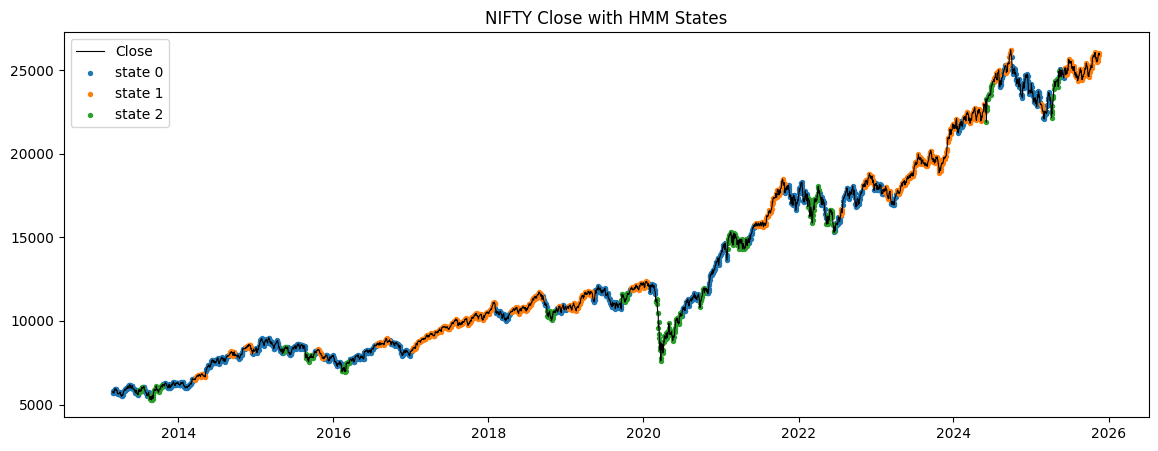

In [22]:
# STEP 6.5: Plot HMM states on price
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(14,5))
ax.plot(df.index, df['Close'], color='black', lw=0.8, label='Close')

unique_states = sorted(df['state_hmm'].unique())
cmap = plt.get_cmap('tab10')

for i, s in enumerate(unique_states):
    idx = df[df['state_hmm'] == s].index
    ax.scatter(idx, df.loc[idx,'Close'], s=8, color=cmap(i), label=f'state {s}')

ax.legend()
ax.set_title("NIFTY Close with HMM States")
plt.show()

In [23]:
# STEP 6.6: Concordance table
ct = pd.crosstab(df['state_hmm'], df['cluster_kmeans'], normalize='index')
print("Proportion of KMeans clusters within each HMM state (rows sum to 1):\n")
display(ct.round(3))

# Also absolute counts
display(pd.crosstab(df['state_hmm'], df['cluster_kmeans']))

Proportion of KMeans clusters within each HMM state (rows sum to 1):



cluster_kmeans,0,1,2
state_hmm,,,
0,0.501,0.499,0.000
1,0.765,0.235,0.000
2,0.466,0.471,0.063


cluster_kmeans,0,1,2
state_hmm,,,
0,750,746,0
1,920,282,0
2,199,201,27


In [24]:
# STEP 6.7: diagnostics
# time spent in each state (percent)
time_pct = df['state_hmm'].value_counts(normalize=True).sort_index()
print("Time % in each state:\n", time_pct.round(4))

# compute average contiguous run length per state
runs = []
current_state = None
current_len = 0
for s in df['state_hmm'].tolist():
    if s == current_state:
        current_len += 1
    else:
        if current_state is not None:
            runs.append((current_state, current_len))
        current_state = s
        current_len = 1
runs.append((current_state, current_len))
runs_df = pd.DataFrame(runs, columns=['state','length'])
avg_run = runs_df.groupby('state')['length'].mean()
print("\nAverage contiguous run length (days) per state:\n", avg_run.round(2))

# transition matrix
trans_mat = pd.DataFrame(hmm_model.transmat_, 
                         index=[f's{int(i)}' for i in range(hmm_model.n_components)],
                         columns=[f's{int(i)}' for i in range(hmm_model.n_components)])
print("\nHMM transition matrix (rows source -> cols target):")
display(trans_mat.round(3))

Time % in each state:
 state_hmm
0    0.4787
1    0.3846
2    0.1366
Name: proportion, dtype: float64

Average contiguous run length (days) per state:
 state
0    45.33
1    60.10
2    30.50
Name: length, dtype: float64

HMM transition matrix (rows source -> cols target):


,s0,s1,s2
s0,0.974,0.016,0.010
s1,0.018,0.981,0.001
s2,0.036,0.000,0.964


In [25]:
import numpy as np
import pandas as pd

def pct_to_log(pct):
    return np.log1p(pct)

def compute_performance(series_nav):
    # series_nav: daily portfolio NAV (index dates)
    # returns daily simple returns
    r = series_nav.pct_change().fillna(0)
    total_return = series_nav.iloc[-1] / series_nav.iloc[0] - 1
    days = (series_nav.index[-1] - series_nav.index[0]).days
    years = days / 365.25
    cagr = (series_nav.iloc[-1] / series_nav.iloc[0]) ** (1 / years) - 1 if years>0 else np.nan
    ann_vol = r.std() * np.sqrt(252)
    ann_sharpe = (r.mean() * 252) / ann_vol if ann_vol>0 else np.nan
    # max drawdown
    cum = series_nav.cummax()
    drawdown = (series_nav - cum) / cum
    max_dd = drawdown.min()
    # win rate
    wins = (r[r!=0] > 0).sum()
    trades = (r[r!=0].shape[0])
    win_rate = wins / trades if trades>0 else np.nan
    return {
        'Total Return': total_return,
        'CAGR': cagr,
        'Annual Vol': ann_vol,
        'Annual Sharpe': ann_sharpe,
        'Max Drawdown': max_dd,
        'Win Rate': win_rate
    }

def plot_nav(df_nav, title="NAV"):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize=(12,5))
    ax.plot(df_nav.index, df_nav.values)
    ax.set_title(title)
    ax.set_ylabel("NAV")
    ax.grid(True)
    plt.show()

In [26]:
df = df.copy()  # ensure safe

# precompute helpers
df['high_20'] = df['Close'].rolling(20).max()
df['low_10']  = df['Close'].rolling(10).min()
df['ma20']    = df['Close'].rolling(20).mean()

# signals initialization
df['signal'] = 0  # 1 means long, 0 means flat

# Trend regime (state 0): breakout logic
trend_mask = df['state_hmm'] == 0
enter_trend = (df['Close'] > df['high_20']) & trend_mask
exit_trend  = (df['Close'] < df['low_10']) & (df['state_hmm'] == 0)

# Mean-revert regime (state 1): buying dip logic
mr_mask = df['state_hmm'] == 1
enter_mr = (df['Close'] < df['ma20'] * 0.98) & mr_mask  # 2% below MA
exit_mr  = (df['Close'] > df['ma20']) & (df['state_hmm'] == 1)

# We'll construct position by forward-filling entries until exits occur
df['entry_trend'] = enter_trend.astype(int)
df['exit_trend']  = exit_trend.astype(int)
df['entry_mr']    = enter_mr.astype(int)
df['exit_mr']     = exit_mr.astype(int)

# Build position series
pos = pd.Series(0, index=df.index)

# apply trend entries/exits
in_trend = False
for idx in df.index:
    if df.at[idx,'entry_trend']:
        in_trend = True
    if df.at[idx,'exit_trend']:
        in_trend = False
    # stay in trend only if current state is 0 (we flatten if state changes)
    pos.at[idx] = 1 if in_trend and df.at[idx,'state_hmm']==0 else 0

# apply mean-revert entries/exits (only when not already in trend position)
in_mr = False
for idx in df.index:
    if pos.at[idx]==1:
        # if already in trend, skip MR
        continue
    if df.at[idx,'entry_mr']:
        in_mr = True
    if df.at[idx,'exit_mr']:
        in_mr = False
    pos.at[idx] = 1 if in_mr and df.at[idx,'state_hmm']==1 else pos.at[idx]

df['position'] = pos

# quick sanity checks
print("Positions value counts:\n", df['position'].value_counts())
print("Sample (last 8) positions:\n", df[['Close','state_hmm','position']].tail(8))

Positions value counts:
 position
0    3054
1      71
Name: count, dtype: int64
Sample (last 8) positions:
                    Close  state_hmm  position
Date                                         
2025-11-07  25492.300781          1         0
2025-11-10  25574.349609          1         0
2025-11-11  25694.949219          1         0
2025-11-12  25875.800781          1         0
2025-11-13  25879.150391          1         0
2025-11-14  25910.050781          1         0
2025-11-17  26013.449219          1         0
2025-11-18  25910.050781          1         0


Strategy metrics:
Total Return : 0.109352
CAGR : 0.00819
Annual Vol : 0.019707
Annual Sharpe : 0.434526
Max Drawdown : -0.046607
Win Rate : 0.633803

Buy & Hold metrics:
Total Return : 3.469639
CAGR : 0.124892
Annual Vol : 0.162973
Annual Sharpe : 0.823064
Max Drawdown : -0.384399
Win Rate : 0.539423


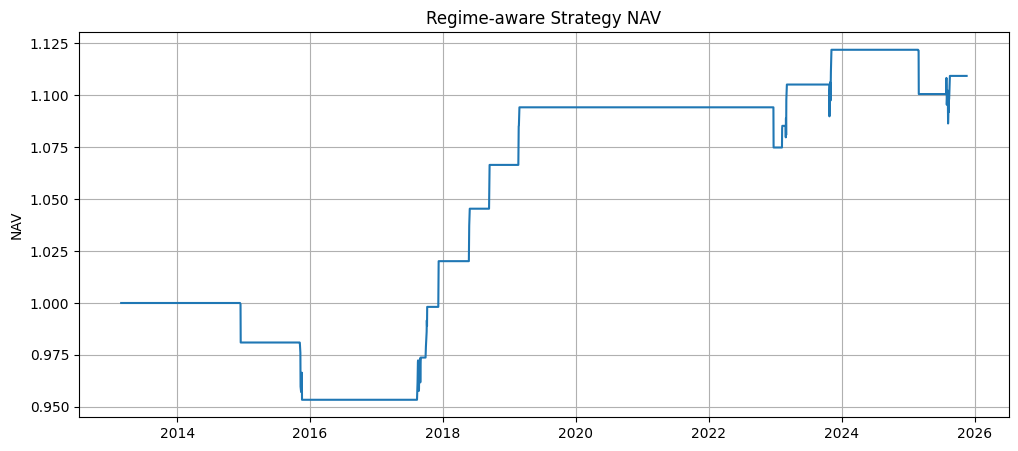

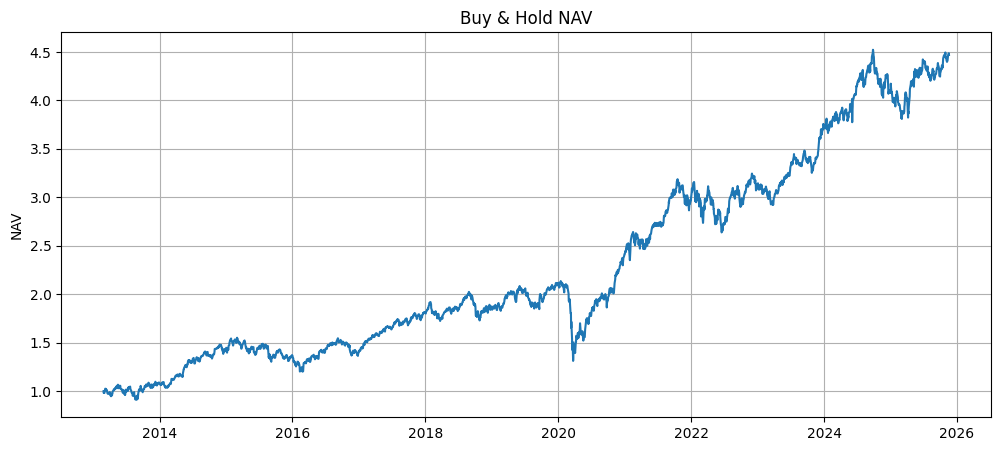

In [27]:
# STEP 7.3: Compute strategy NAV vs Buy & Hold

df['ret_close'] = df['Close'].pct_change().fillna(0)

df['pos_lag'] = df['position'].shift(1).fillna(0)
df['strat_ret'] = df['pos_lag'] * df['ret_close']

df['nav_strat'] = (1 + df['strat_ret']).cumprod()
df['nav_bnh'] = (1 + df['ret_close']).cumprod()

metrics_strat = compute_performance(df['nav_strat'])
metrics_bnh   = compute_performance(df['nav_bnh'])

print("Strategy metrics:")
for k,v in metrics_strat.items():
    print(k, ":", round(v,6))

print("\nBuy & Hold metrics:")
for k,v in metrics_bnh.items():
    print(k, ":", round(v,6))

plot_nav(df['nav_strat'], title="Regime-aware Strategy NAV")
plot_nav(df['nav_bnh'], title="Buy & Hold NAV")

Improved strategy v2 metrics:
Total Return : 0.234866
CAGR : 0.01672
Annual Vol : 0.030403
Annual Sharpe : 0.574733
Max Drawdown : -0.07194
Win Rate : 0.560847

Buy & Hold metrics (same as before):
Total Return : 3.469639
CAGR : 0.124892
Annual Vol : 0.162973
Annual Sharpe : 0.823064
Max Drawdown : -0.384399
Win Rate : 0.539423

Exposure (fraction days invested): 0.0605
Number of entries: 30


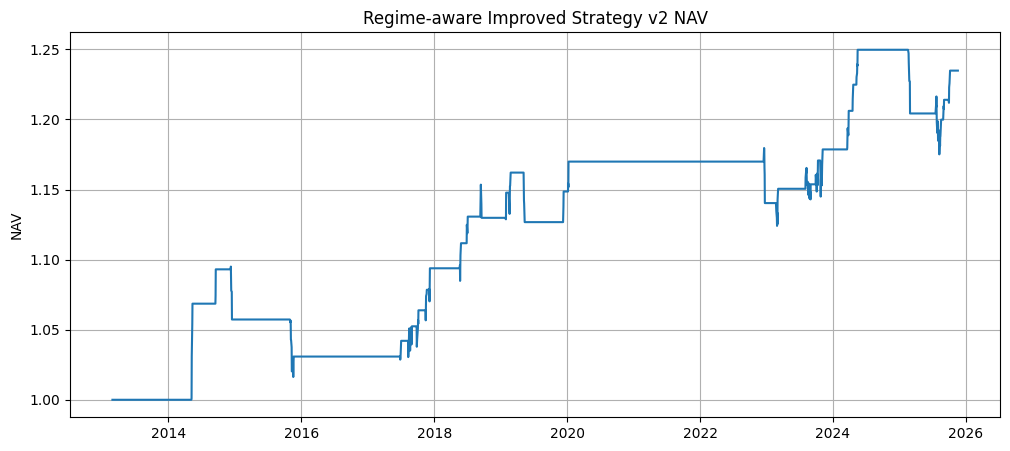

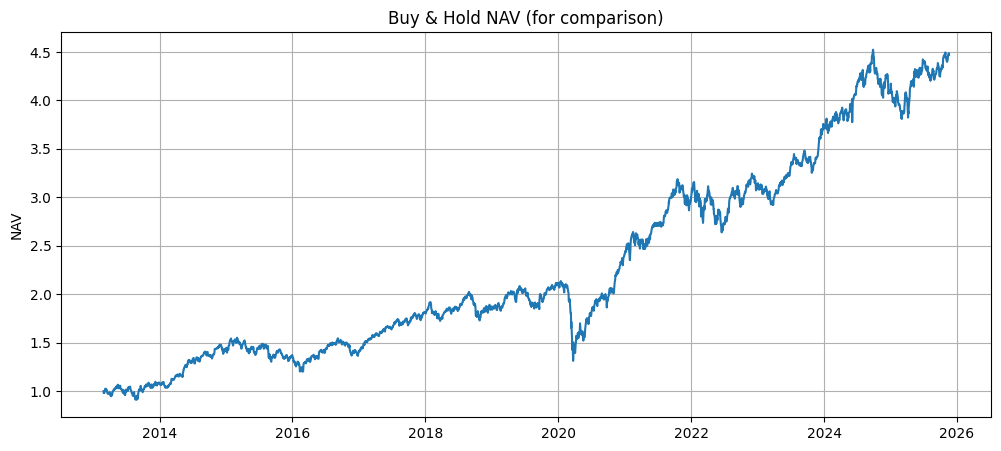

In [28]:
# ===== Improved strategy variant v2 =====
df2 = df.copy()

# helper windows
df2['high_10'] = df2['Close'].rolling(10).max()
df2['low_5']   = df2['Close'].rolling(5).min()
df2['ma10']    = df2['Close'].rolling(10).mean()
df2['ma20']    = df2['Close'].rolling(20).mean()

# rules (relaxed)
enter_trend_v2 = (df2['Close'] > df2['high_10']) & (df2['state_hmm']==0)
exit_trend_v2  = (df2['Close'] < df2['low_5'])  & (df2['state_hmm']==0)

enter_mr_v2 = (df2['Close'] < df2['ma20'] * 0.99) & (df2['state_hmm']==1)  # 1% below MA
exit_mr_v2  = (df2['Close'] > df2['ma20']) & (df2['state_hmm']==1)

# we'll allow a 3-day tolerance to keep a trade active even if state flips briefly
tolerance_days = 3

pos_v2 = pd.Series(0, index=df2.index)
in_trade = False
trade_entry_price = None
trade_type = None  # 'trend' or 'mr'
trade_day_counter = 0

for t in df2.index:
    # check new entries if not in trade
    if not in_trade:
        if enter_trend_v2.at[t]:
            in_trade = True
            trade_type = 'trend'
            trade_entry_price = df2.at[t,'Close']
            trade_day_counter = 0
            pos_v2.at[t] = 1
            continue
        if enter_mr_v2.at[t]:
            in_trade = True
            trade_type = 'mr'
            trade_entry_price = df2.at[t,'Close']
            trade_day_counter = 0
            pos_v2.at[t] = 1
            continue
        pos_v2.at[t] = 0
    else:
        # inside a trade: check stoploss / takeprofit relative to entry
        curp = df2.at[t,'Close']
        ret_from_entry = (curp / trade_entry_price) - 1
        stop_loss = -0.03    # -3%
        take_profit = 0.06   # +6%
        if ret_from_entry <= stop_loss or ret_from_entry >= take_profit:
            # exit immediately
            in_trade = False
            trade_entry_price = None
            trade_type = None
            trade_day_counter = 0
            pos_v2.at[t] = 0
            continue

        # regular exit conditions by rule (but allow tolerance_days)
        trade_day_counter += 1

        if trade_type == 'trend':
            # if still in state 0 and not failing exit rule, remain; if state flips, allow short tolerance
            if (exit_trend_v2.at[t] and df2.at[t,'state_hmm']==0):
                in_trade = False
                pos_v2.at[t] = 0
                trade_entry_price = None
                trade_type = None
                trade_day_counter = 0
                continue
            # if state not 0, allow tolerance up to tolerance_days
            if df2.at[t,'state_hmm'] != 0 and trade_day_counter > tolerance_days:
                in_trade = False
                pos_v2.at[t] = 0
                trade_entry_price = None
                trade_type = None
                trade_day_counter = 0
                continue
            pos_v2.at[t] = 1

        elif trade_type == 'mr':
            if (exit_mr_v2.at[t] and df2.at[t,'state_hmm']==1):
                in_trade = False
                pos_v2.at[t] = 0
                trade_entry_price = None
                trade_type = None
                trade_day_counter = 0
                continue
            if df2.at[t,'state_hmm'] != 1 and trade_day_counter > tolerance_days:
                in_trade = False
                pos_v2.at[t] = 0
                trade_entry_price = None
                trade_type = None
                trade_day_counter = 0
                continue
            pos_v2.at[t] = 1

# attach position and compute returns
df2['position_v2'] = pos_v2
df2['pos_v2_lag'] = df2['position_v2'].shift(1).fillna(0)
df2['strat_v2_ret'] = df2['pos_v2_lag'] * df2['ret_close']
df2['nav_v2'] = (1 + df2['strat_v2_ret']).cumprod()
metrics_v2 = compute_performance(df2['nav_v2'])
metrics_bnh = compute_performance(df2['nav_bnh'])

print("Improved strategy v2 metrics:")
for k,v in metrics_v2.items():
    print(k, ":", round(v,6))
print("\nBuy & Hold metrics (same as before):")
for k,v in metrics_bnh.items():
    print(k, ":", round(v,6))

# exposure and entries
exposure_v2 = df2['pos_v2_lag'].mean()
n_entries_v2 = (df2['position_v2'].diff().fillna(0)==1).sum()
print("\nExposure (fraction days invested):", round(exposure_v2,4))
print("Number of entries:", int(n_entries_v2))

# quick NAV plot
plot_nav(df2['nav_v2'], title="Regime-aware Improved Strategy v2 NAV")
plot_nav(df2['nav_bnh'], title="Buy & Hold NAV (for comparison)")

Regime-Volatility Adjusted Strategy (v3) metrics:
Total Return : 0.21582
CAGR : 0.015478
Annual Vol : 0.035977
Annual Sharpe : 0.455952
Max Drawdown : -0.086969
Win Rate : 0.560847

Exposure: 0.0605
Weighted avg exposure (avg weight * pos): 0.0629


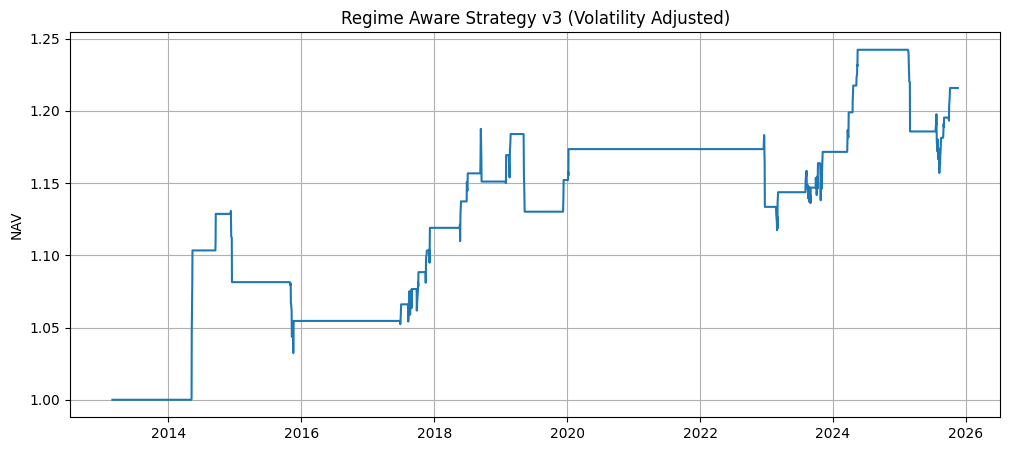

In [29]:
# ===== Step 7.6: Volatility-Adjusted Position Sizing (RVS) =====
df3 = df2.copy()

# map state to weights
state_weights = {
    0: 1.5,   # trend
    1: 1.0,   # choppy
    2: 0.3    # panic (defensive)
}

df3['weight'] = df3['state_hmm'].map(state_weights)

# strategy return with position size
df3['strat_v3_ret'] = df3['pos_v2_lag'] * df3['ret_close'] * df3['weight']

# NAV
df3['nav_v3'] = (1 + df3['strat_v3_ret']).cumprod()

metrics_v3 = compute_performance(df3['nav_v3'])

print("Regime-Volatility Adjusted Strategy (v3) metrics:")
for k,v in metrics_v3.items():
    print(k, ":", round(v,6))

print("\nExposure:", round(df3['pos_v2_lag'].mean(), 4))
print("Weighted avg exposure (avg weight * pos):", round((df3['pos_v2_lag']*df3['weight']).mean(),4))

plot_nav(df3['nav_v3'], title="Regime Aware Strategy v3 (Volatility Adjusted)")

<Axes: title={'center': 'RSI(2)'}, xlabel='Date'>

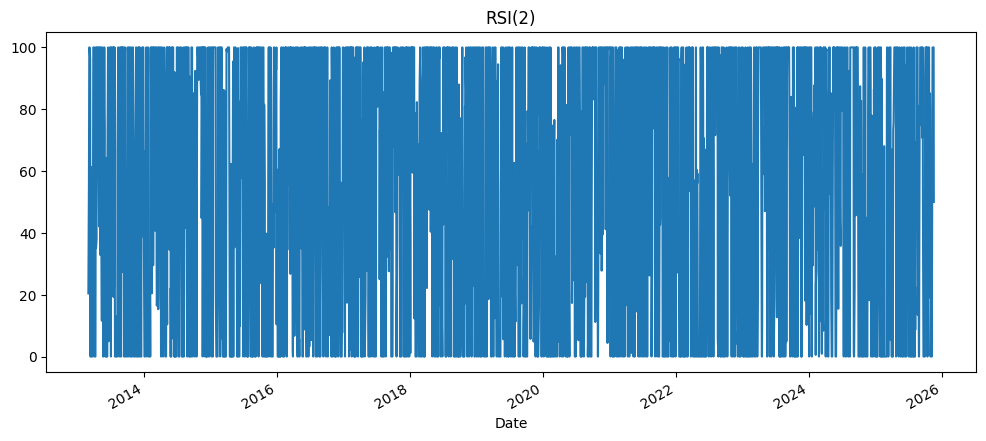

In [30]:
# ===== Step 8.1: RSI(2) Calculation =====

def compute_rsi(series, length=2):
    delta = series.diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    ma_up = up.rolling(length).mean()
    ma_down = down.rolling(length).mean()
    rsi = 100 * ma_up / (ma_up + ma_down)
    return rsi

df['rsi2'] = compute_rsi(df['Close'], 2)
df['rsi2'].plot(figsize=(12,5), title="RSI(2)")

In [31]:
# ===== Step 8.2: MR strategy for State 1 =====

df_mr = df.copy()

enter_cond = (df_mr['rsi2'] < 10) & (df_mr['state_hmm'] == 1)
exit_cond  = (df_mr['rsi2'] > 70) & (df_mr['state_hmm'] == 1)

# max holding days limit
max_hold = 5

pos = pd.Series(0, index=df_mr.index)
in_trade = False
days_in = 0

for t in df_mr.index:
    if not in_trade:
        if enter_cond.at[t]:
            in_trade = True
            days_in = 0
            pos.at[t] = 1
        else:
            pos.at[t] = 0
    else:
        days_in += 1
        # exit if exit condition met OR holding too long OR state changed
        if exit_cond.at[t] or days_in > max_hold or df_mr.at[t,'state_hmm'] != 1:
            in_trade = False
            pos.at[t] = 0
        else:
            pos.at[t] = 1

df_mr['pos_mr'] = pos

# preview
df_mr[['Close','state_hmm','rsi2','pos_mr']].tail(10)


,Close,state_hmm,rsi2,pos_mr
Date,,,,
2025-11-04,25597.650391,1,19.932426,1
2025-11-06,25509.699219,1,0.000000,1
2025-11-07,25492.300781,1,0.000000,1
2025-11-10,25574.349609,1,82.504861,0
2025-11-11,25694.949219,1,100.000000,0
2025-11-12,25875.800781,1,100.000000,0
2025-11-13,25879.150391,1,100.000000,0
2025-11-14,25910.050781,1,100.000000,0
2025-11-17,26013.449219,1,100.000000,0


Mean-Reversion Strategy (State 1 Only) Metrics:
Total Return : 0.257375
CAGR : 0.018164
Annual Vol : 0.040576
Annual Sharpe : 0.475437
Max Drawdown : -0.089907
Win Rate : 0.550129


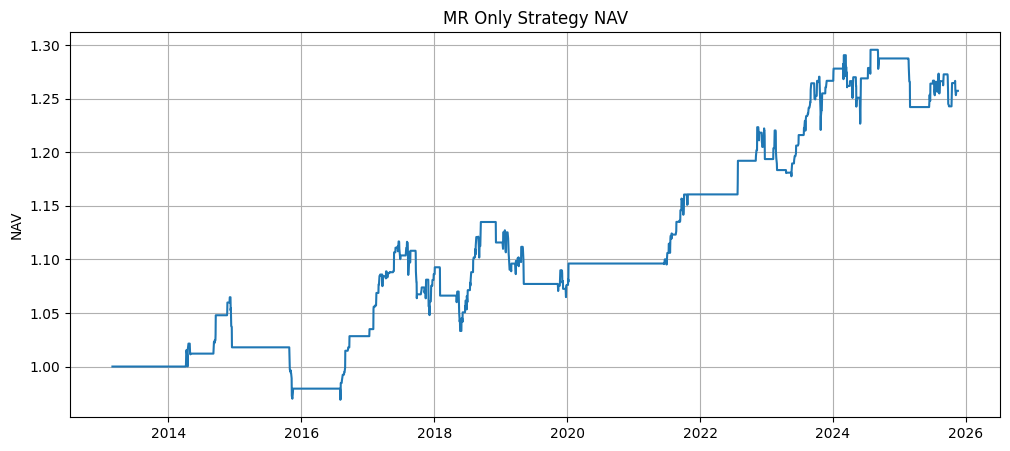

In [32]:
# ===== Step 8.3: Returns & NAV for MR strategy =====
df_mr['pos_mr_lag'] = df_mr['pos_mr'].shift(1).fillna(0)
df_mr['mr_ret'] = df_mr['pos_mr_lag'] * df_mr['ret_close']

df_mr['nav_mr'] = (1 + df_mr['mr_ret']).cumprod()

metrics_mr = compute_performance(df_mr['nav_mr'])

print("Mean-Reversion Strategy (State 1 Only) Metrics:")
for k,v in metrics_mr.items():
    print(k, ":", round(v,6))

plot_nav(df_mr['nav_mr'], title="MR Only Strategy NAV")


--- MR v2 (State 1 only) metrics ---
Total Return : 0.036981
CAGR : 0.002858
Annual Vol : 0.014513
Annual Sharpe : 0.209045
Max Drawdown : -0.040251
Win Rate : 0.638889

Exposure (fraction of days invested): 0.0115
Number of entries: 15


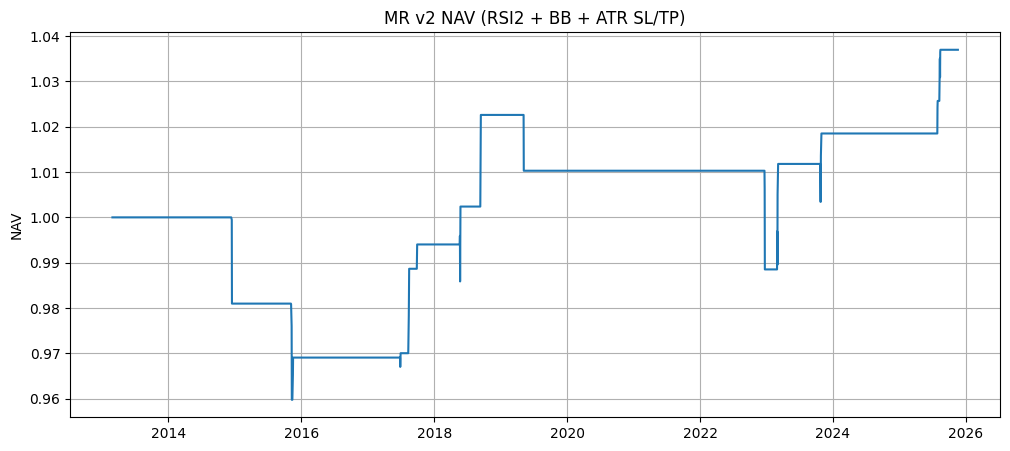

In [33]:
# ===== STEP: MR v2 (RSI2 + Bollinger + ATR SL/TP + max-hold) =====

import numpy as np
import pandas as pd

# ensure we have close & ret_close & rsi2
data = df.copy()

# indicators
data['bb_mid'] = data['Close'].rolling(20).mean()
data['bb_std'] = data['Close'].rolling(20).std()
data['bb_upper'] = data['bb_mid'] + 2 * data['bb_std']
data['bb_lower'] = data['bb_mid'] - 2 * data['bb_std']

# ATR(14)
high_low = data['High'] - data['Low']
high_prevclose = (data['High'] - data['Close'].shift(1)).abs()
low_prevclose  = (data['Low'] - data['Close'].shift(1)).abs()
tr = pd.concat([high_low, high_prevclose, low_prevclose], axis=1).max(axis=1)
data['atr14'] = tr.rolling(14).mean()

# params
max_hold = 7
sl_atr = 1.0   # stop loss = 1 ATR
tp_atr = 2.0   # take profit = 2 ATR

# entry/exit conditions (only in state 1)
enter_cond = (data['state_hmm'] == 1) & (data['rsi2'] < 10) & (data['Close'] < data['bb_lower'])
# exits: rsi or price to mid band or sl/tp or state change or max hold
exit_rsi = (data['rsi2'] > 70)
exit_mid = (data['Close'] > data['bb_mid'])

# simulate trades with ATR SL/TP and max hold
pos = pd.Series(0, index=data.index)
in_trade = False
entry_price = None
entry_atr = None
days_in = 0

for t in data.index:
    if not in_trade:
        if enter_cond.at[t] and not np.isnan(data.at[t,'atr14']):
            in_trade = True
            entry_price = data.at[t,'Close']
            entry_atr = data.at[t,'atr14']
            days_in = 0
            pos.at[t] = 1
        else:
            pos.at[t] = 0
    else:
        days_in += 1
        curp = data.at[t,'Close']
        # check sl/tp
        if (curp <= entry_price - sl_atr * entry_atr) or (curp >= entry_price + tp_atr * entry_atr):
            in_trade = False
            entry_price = None
            entry_atr = None
            days_in = 0
            pos.at[t] = 0
            continue
        # exit by rsi or mid band or state change or hold limit
        if exit_rsi.at[t] or exit_mid.at[t] or data.at[t,'state_hmm'] != 1 or days_in > max_hold:
            in_trade = False
            entry_price = None
            entry_atr = None
            days_in = 0
            pos.at[t] = 0
            continue
        # otherwise stay long
        pos.at[t] = 1

data['pos_mrv2'] = pos
data['pos_mrv2_lag'] = data['pos_mrv2'].shift(1).fillna(0)
data['mr_v2_ret'] = data['pos_mrv2_lag'] * data['ret_close']

# NAV and metrics
data['nav_mr_v2'] = (1 + data['mr_v2_ret']).cumprod()

def pretty_print_metrics(series_nav, label="NAV"):
    mets = compute_performance(series_nav)
    print(f"--- {label} metrics ---")
    for k,v in mets.items():
        print(f"{k} : {round(v,6)}")
    return mets

mets_mrv2 = pretty_print_metrics(data['nav_mr_v2'], label="MR v2 (State 1 only)")
exposure = data['pos_mrv2_lag'].mean()
entries = (data['pos_mrv2'].diff().fillna(0)==1).sum()
print("\nExposure (fraction of days invested):", round(exposure,4))
print("Number of entries:", int(entries))

# plot NAV
plot_nav(data['nav_mr_v2'], title="MR v2 NAV (RSI2 + BB + ATR SL/TP)")

=== MR v2.5 Metrics ===
Total Return : 0.111327
CAGR : 0.008331
Annual Vol : 0.028719
Annual Sharpe : 0.310712
Max Drawdown : -0.067746
Win Rate : 0.511111

Exposure: 0.0579
Number of MR v2.5 entries: 68


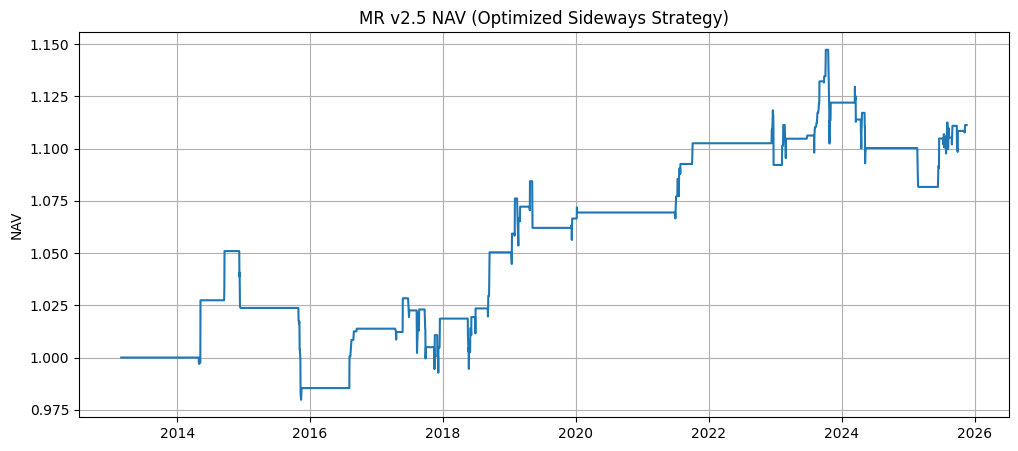

In [34]:
# ===== MR v2.5 (RSI2 < 15 + MA20 filter + mid-band exit + max_hold 4) =====

mrv = df.copy()

# Indicators (already computed but recomputing for safety)
mrv['ma20'] = mrv['Close'].rolling(20).mean()
mrv['bb_mid'] = mrv['ma20']

# Entry conditions:
enter = (mrv['state_hmm'] == 1) & (mrv['rsi2'] < 15) & (mrv['Close'] < mrv['ma20'])

# Exit conditions:
exit_rsi  = (mrv['rsi2'] > 60)
exit_ma20 = (mrv['Close'] > mrv['ma20'])

max_hold = 4
pos = pd.Series(0, index=mrv.index)
in_trade = False
days_in = 0

for t in mrv.index:
    if not in_trade:
        if enter.at[t]:
            in_trade = True
            days_in = 0
            pos.at[t] = 1
        else:
            pos.at[t] = 0
    else:
        days_in += 1
        # exit conditions:
        if exit_rsi.at[t] or exit_ma20.at[t] or mrv.at[t,'state_hmm'] != 1 or days_in > max_hold:
            in_trade = False
            days_in = 0
            pos.at[t] = 0
        else:
            pos.at[t] = 1

mrv['pos_mrv25'] = pos
mrv['pos_mrv25_lag'] = mrv['pos_mrv25'].shift(1).fillna(0)
mrv['ret_mrv25'] = mrv['pos_mrv25_lag'] * mrv['ret_close']
mrv['nav_mrv25'] = (1 + mrv['ret_mrv25']).cumprod()

print("=== MR v2.5 Metrics ===")
metrics_25 = compute_performance(mrv['nav_mrv25'])
for k,v in metrics_25.items():
    print(k, ":", round(v,6))

# exposure & entries
exp25 = mrv['pos_mrv25_lag'].mean()
entries25 = (mrv['pos_mrv25'].diff().fillna(0)==1).sum()

print("\nExposure:", round(exp25,4))
print("Number of MR v2.5 entries:", int(entries25))

plot_nav(mrv['nav_mrv25'], "MR v2.5 NAV (Optimized Sideways Strategy)")

In [35]:
# ===== Trend indicators (RSI14, MA20, MA50, High20, Low10) =====

trd = df.copy()

# MA
trd['ma20'] = trd['Close'].rolling(20).mean()
trd['ma50'] = trd['Close'].rolling(50).mean()

# RSI 14
def compute_rsi(series, length=14):
    delta = series.diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    ma_up = up.rolling(length).mean()
    ma_down = down.rolling(length).mean()
    rsi = 100 * ma_up / (ma_up + ma_down)
    return rsi

trd['rsi14'] = compute_rsi(trd['Close'], 14)

# Breakout windows
trd['high20'] = trd['Close'].rolling(20).max()
trd['low10'] = trd['Close'].rolling(10).min()

print("Indicators calculated.")

Indicators calculated.


=== Trend v2 Metrics ===
Total Return : 0.162424
CAGR : 0.0119
Annual Vol : 0.069751
Annual Sharpe : 0.208929
Max Drawdown : -0.170484
Win Rate : 0.541131

Exposure: 0.2493
Number of Trend v2 entries: 47


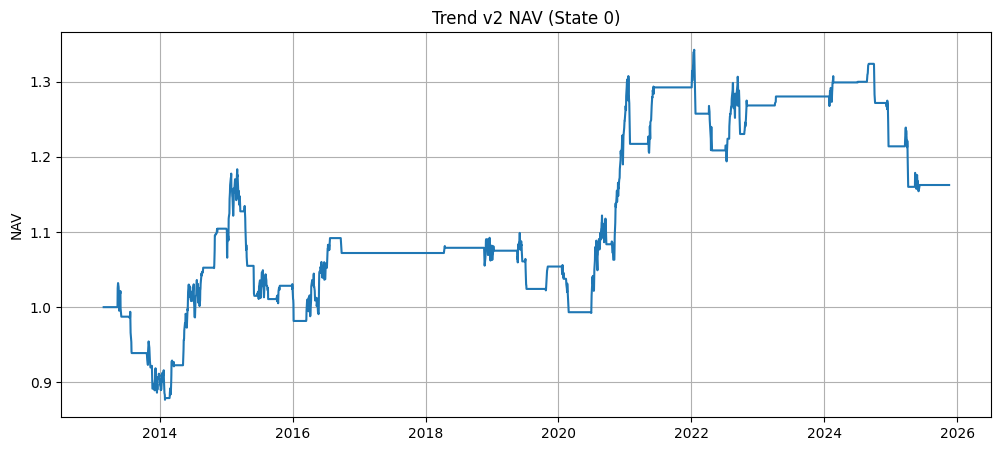

In [36]:
# ===== Trend Strategy v2 (State 0 only) =====

enter_trend = (
    (trd['state_hmm'] == 0) &
    ((trd['Close'] > trd['high20']) | (trd['Close'] > trd['ma20'])) &
    (trd['Close'] > trd['ma50']) &
    (trd['rsi14'] > 50)
)

exit_trend = (
    (trd['state_hmm'] != 0) |
    (trd['Close'] < trd['low10']) |
    (trd['rsi14'] < 40)
)

pos = pd.Series(0, index=trd.index)
in_trade = False

for t in trd.index:
    if not in_trade:
        if enter_trend.at[t]:
            in_trade = True
            pos.at[t] = 1
        else:
            pos.at[t] = 0
    else:
        if exit_trend.at[t]:
            in_trade = False
            pos.at[t] = 0
        else:
            pos.at[t] = 1

trd['pos_trend'] = pos
trd['pos_trend_lag'] = trd['pos_trend'].shift(1).fillna(0)
trd['ret_trend'] = trd['pos_trend_lag'] * trd['ret_close']

trd['nav_trend'] = (1 + trd['ret_trend']).cumprod()

metrics_trend = compute_performance(trd['nav_trend'])

print("=== Trend v2 Metrics ===")
for k,v in metrics_trend.items():
    print(k, ":", round(v,6))

# exposure + entries
exp_trd = trd['pos_trend_lag'].mean()
entries_trd = (trd['pos_trend'].diff().fillna(0)==1).sum()

print("\nExposure:", round(exp_trd,4))
print("Number of Trend v2 entries:", int(entries_trd))

plot_nav(trd['nav_trend'], "Trend v2 NAV (State 0)")


=== Trend v3 (Correct Trailing Stop) ===
Total Return : 0.167329
CAGR : 0.012235
Annual Vol : 0.066724
Annual Sharpe : 0.220399
Max Drawdown : -0.189421
Win Rate : 0.543716

Exposure: 0.2346
Entries: 53


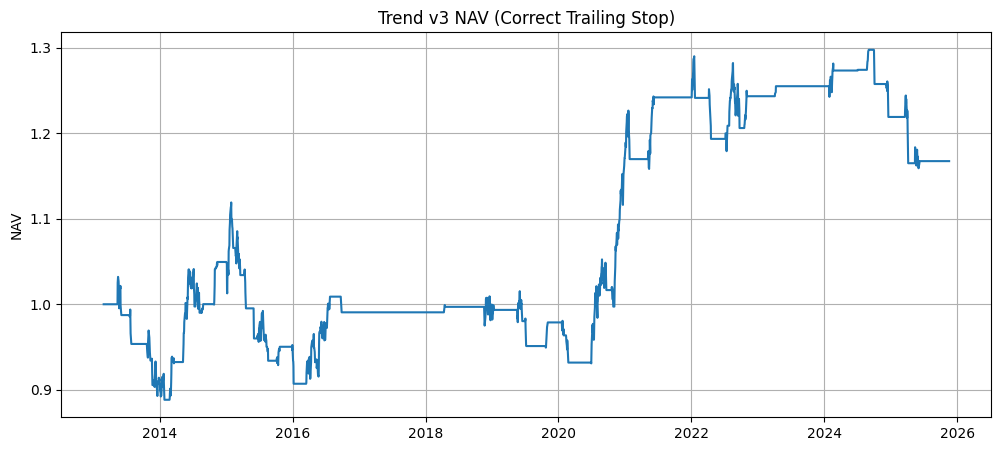

In [38]:
# ===== Trend v3 (Correct Trailing Stop) =====

trd3 = df.copy()

# indicators
trd3['ma20'] = trd3['Close'].rolling(20).mean()
trd3['ma50'] = trd3['Close'].rolling(50).mean()
trd3['rsi14'] = compute_rsi(trd3['Close'], 14)
trd3['high20'] = trd3['Close'].rolling(20).max()

# ATR 14
hl = trd3['High'] - trd3['Low']
hp = (trd3['High'] - trd3['Close'].shift(1)).abs()
lp = (trd3['Low'] - trd3['Close'].shift(1)).abs()
trd3['tr'] = pd.concat([hl, hp, lp], axis=1).max(axis=1)
trd3['atr14'] = trd3['tr'].rolling(14).mean()

# entry
enter_trend = (
    (trd3['state_hmm'] == 0) &
    (trd3['Close'] > trd3['ma50']) &
    ((trd3['Close'] > trd3['high20']) | (trd3['Close'] > trd3['ma20'])) &
    (trd3['rsi14'] > 50)
)

exit_rsi = trd3['rsi14'] < 40
exit_state = trd3['state_hmm'] != 0

pos = pd.Series(0, index=trd3.index)
in_trade = False
highest = None

for t in trd3.index:
    if not in_trade:
        if enter_trend.at[t] and not np.isnan(trd3.at[t,'atr14']):
            in_trade = True
            pos.at[t] = 1
            highest = trd3.at[t,'Close']
        else:
            pos.at[t] = 0
    else:
        cur = trd3.at[t,'Close']
        atr = trd3.at[t,'atr14']
        
        # update highest price since entry
        highest = max(highest, cur)
        
        # trailing stop = highest - 3 ATR
        trailing_stop = highest - 3 * atr
        
        if (cur < trailing_stop) or exit_rsi.at[t] or exit_state.at[t]:
            in_trade = False
            pos.at[t] = 0
            highest = None
        else:
            pos.at[t] = 1

trd3['pos_trend3'] = pos
trd3['pos_trend3_lag'] = trd3['pos_trend3'].shift(1).fillna(0)
trd3['ret_trend3'] = trd3['pos_trend3_lag'] * trd3['ret_close']

trd3['nav_trend3'] = (1 + trd3['ret_trend3']).cumprod()

m3 = compute_performance(trd3['nav_trend3'])

print("=== Trend v3 (Correct Trailing Stop) ===")
for k,v in m3.items():
    print(k, ":", round(v,6))

exp3 = trd3['pos_trend3_lag'].mean()
entries3 = (trd3['pos_trend3'].diff().fillna(0)==1).sum()

print("\nExposure:", round(exp3,4))
print("Entries:", entries3)

plot_nav(trd3['nav_trend3'], "Trend v3 NAV (Correct Trailing Stop)")

=== Panic v2 Metrics ===
Total Return : -0.135827
CAGR : -0.011409
Annual Vol : 0.042988
Annual Sharpe : -0.251707
Max Drawdown : -0.208802
Win Rate : 0.5

Exposure: 0.0045
Entries: 6


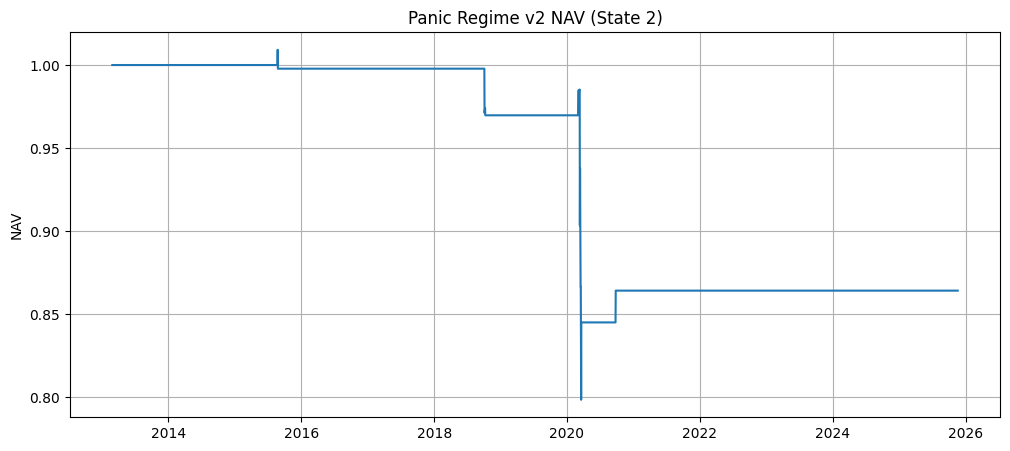

In [39]:
# ===== Panic Regime Strategy v2 (State 2 only) =====

panic = df.copy()

# indicators
panic['ma10'] = panic['Close'].rolling(10).mean()
panic['bb_mid'] = panic['Close'].rolling(20).mean()
panic['bb_std'] = panic['Close'].rolling(20).std()
panic['bb_lower'] = panic['bb_mid'] - 2 * panic['bb_std']

# ATR 20
hl = panic['High'] - panic['Low']
hp = (panic['High'] - panic['Close'].shift(1)).abs()
lp = (panic['Low'] - panic['Close'].shift(1)).abs()
panic['tr'] = pd.concat([hl, hp, lp], axis=1).max(axis=1)
panic['atr20'] = panic['tr'].rolling(20).mean()

# ATR spike threshold
panic['atr_spike'] = panic['atr20'] > 1.2 * panic['atr20'].rolling(20).mean()

# ENTRY conditions
enter_panic = (
    (panic['state_hmm'] == 2) &
    (panic['rsi2'] < 5) &
    (panic['Close'] < panic['bb_lower']) &
    (panic['atr_spike'])
)

# EXIT conditions
exit_rsi = panic['rsi2'] > 40
exit_ma = panic['Close'] > panic['ma10']
exit_state = panic['state_hmm'] != 2

max_hold = 3
pos = pd.Series(0, index=panic.index)
in_trade = False
days_in = 0

for t in panic.index:
    if not in_trade:
        if enter_panic.at[t]:
            in_trade = True
            days_in = 0
            pos.at[t] = 1
        else:
            pos.at[t] = 0
    else:
        days_in += 1
        if exit_rsi.at[t] or exit_ma.at[t] or exit_state.at[t] or days_in > max_hold:
            in_trade = False
            days_in = 0
            pos.at[t] = 0
        else:
            pos.at[t] = 1

panic['pos_panic'] = pos
panic['pos_panic_lag'] = panic['pos_panic'].shift(1).fillna(0)
panic['ret_panic'] = panic['pos_panic_lag'] * panic['ret_close']

panic['nav_panic'] = (1 + panic['ret_panic']).cumprod()

# metrics
print("=== Panic v2 Metrics ===")
m_panic = compute_performance(panic['nav_panic'])
for k,v in m_panic.items():
    print(k, ":", round(v,6))

exp_panic = panic['pos_panic_lag'].mean()
entries_panic = (panic['pos_panic'].diff().fillna(0)==1).sum()
print("\nExposure:", round(exp_panic,4))
print("Entries:", entries_panic)

plot_nav(panic['nav_panic'], "Panic Regime v2 NAV (State 2)")


=== Panic v3 Metrics ===
Total Return : 0.115691
CAGR : 0.008642
Annual Vol : 0.041742
Annual Sharpe : 0.232676
Max Drawdown : -0.139183
Win Rate : 0.666667

Exposure: 0.0106
Entries: 14


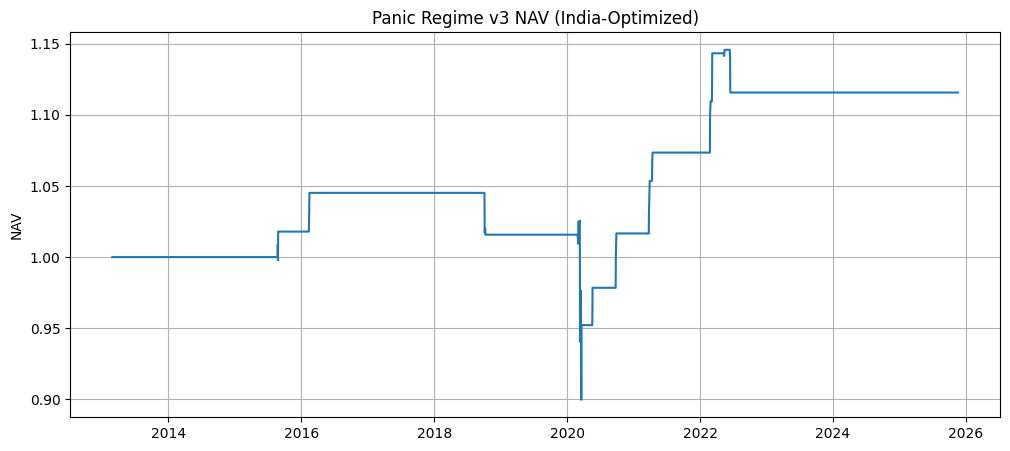

In [40]:
# ===== Panic v3 (India-Optimized Crash Mean Reversion) =====

pv3 = df.copy()

# indicators
pv3['ma5'] = pv3['Close'].rolling(5).mean()
pv3['bb_mid'] = pv3['Close'].rolling(20).mean()
pv3['bb_std'] = pv3['Close'].rolling(20).std()
pv3['bb_lower'] = pv3['bb_mid'] - 2 * pv3['bb_std']

# ENTRY: softer thresholds
enter_p3 = (
    (pv3['state_hmm'] == 2) &
    (pv3['rsi2'] < 15) &
    (pv3['Close'] < pv3['bb_lower'])
)

# EXIT
exit_rsi = pv3['rsi2'] > 50
exit_ma5 = pv3['Close'] > pv3['ma5']
exit_state = pv3['state_hmm'] != 2

max_hold = 2
pos = pd.Series(0, index=pv3.index)
in_trade = False
days_in = 0

for t in pv3.index:
    if not in_trade:
        if enter_p3.at[t]:
            in_trade = True
            days_in = 0
            pos.at[t] = 1
        else:
            pos.at[t] = 0
    else:
        days_in += 1
        if exit_rsi.at[t] or exit_ma5.at[t] or exit_state.at[t] or days_in > max_hold:
            in_trade = False
            days_in = 0
            pos.at[t] = 0
        else:
            pos.at[t] = 1

pv3['pos_p3'] = pos
pv3['pos_p3_lag'] = pv3['pos_p3'].shift(1).fillna(0)
pv3['ret_p3'] = pv3['pos_p3_lag'] * pv3['ret_close']

pv3['nav_p3'] = (1 + pv3['ret_p3']).cumprod()

# metrics
print("=== Panic v3 Metrics ===")
m_p3 = compute_performance(pv3['nav_p3'])
for k,v in m_p3.items():
    print(k, ":", round(v,6))

exp_p3 = pv3['pos_p3_lag'].mean()
entries_p3 = (pv3['pos_p3'].diff().fillna(0)==1).sum()
print("\nExposure:", round(exp_p3,4))
print("Entries:", entries_p3)

plot_nav(pv3['nav_p3'], "Panic Regime v3 NAV (India-Optimized)")

=== MASTER STRATEGY v4 METRICS ===
Total Return : 0.506041
CAGR : 0.032709
Annual Vol : 0.10798
Annual Sharpe : 0.359915
Max Drawdown : -0.292485
Win Rate : 0.541799

Exposure: 0.303
Entries: 133


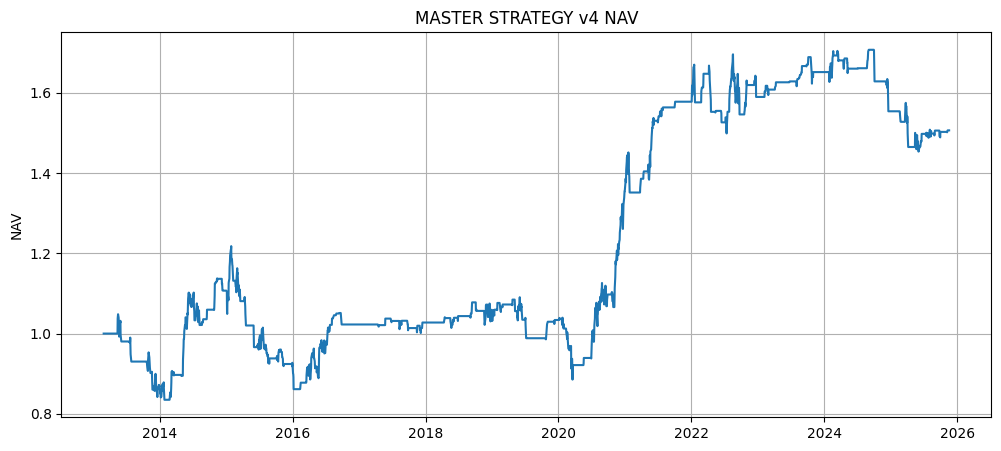

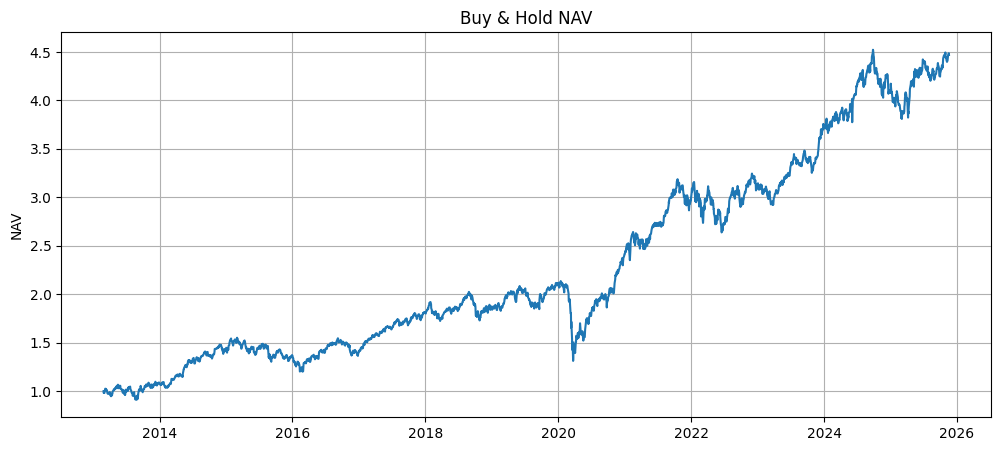

In [41]:
# ===== MASTER STRATEGY v4 =====

master = df.copy()

# Bring in subsystem positions
master['pos_trend'] = trd3['pos_trend3']        # Trend v3
master['pos_mr'] = mrv['pos_mrv25']             # MR v2.5
master['pos_panic'] = pv3['pos_p3']             # Panic v3

# 1) Regime override priority: 
# Panic > MR > Trend
master['final_pos'] = 0

for t in master.index:
    if master.at[t, 'pos_panic'] == 1:
        master.at[t, 'final_pos'] = 1
    elif master.at[t, 'pos_mr'] == 1:
        master.at[t, 'final_pos'] = 1
    elif master.at[t, 'pos_trend'] == 1:
        master.at[t, 'final_pos'] = 1
    else:
        master.at[t, 'final_pos'] = 0
        
# 2) Volatility-based sizing
weights = {
    0: 1.5,   # Trend regime
    1: 1.0,   # Sideways MR
    2: 0.7    # Panic regime
}

master['regime_weight'] = master['state_hmm'].map(weights)

# 3) Final weighted position
master['final_pos_lag'] = master['final_pos'].shift(1).fillna(0)
master['final_weighted_pos'] = master['final_pos_lag'] * master['regime_weight']

# 4) Strategy returns
master['final_ret'] = master['final_weighted_pos'] * master['ret_close']

# 5) NAV
master['nav_final'] = (1 + master['final_ret']).cumprod()

# 6) Metrics
print("=== MASTER STRATEGY v4 METRICS ===")
metrics_final = compute_performance(master['nav_final'])
for k,v in metrics_final.items():
    print(k, ":", round(v,6))

# Exposure
exp_final = master['final_pos_lag'].mean()
print("\nExposure:", round(exp_final,4))

# Entries
entries_final = (master['final_pos'].diff().fillna(0)==1).sum()
print("Entries:", entries_final)

# 7) Plot final NAV
plot_nav(master['nav_final'], "MASTER STRATEGY v4 NAV")

# 8) Plot Buy & Hold for comparison
plot_nav(master['nav_bnh'], "Buy & Hold NAV")

=== MASTER STRATEGY v5 (Balanced) METRICS ===
Total Return : 0.178697
CAGR : 0.013006
Annual Vol : 0.045262
Annual Sharpe : 0.315565
Max Drawdown : -0.138987
Win Rate : 0.53545

Exposure (days invested): 0.303
Number of entries (total): 133

Regime diagnostics (state | total return contribution | ann vol | fraction of days | days invested):
 state  sum_ret  ann_vol  days_frac  days_invested
     0 0.101621 0.059452     0.4787            719
     1 0.057697 0.025140     0.3846            194
     2 0.017802 0.028936     0.1366             34


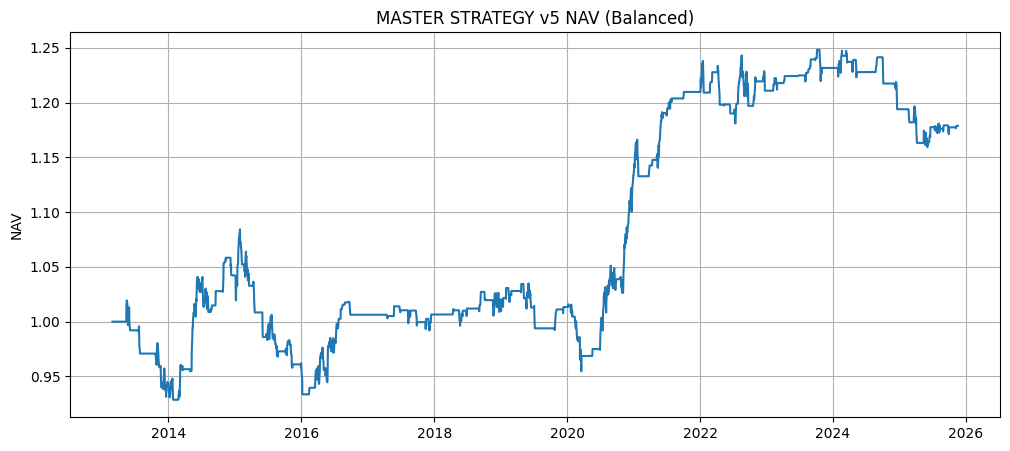

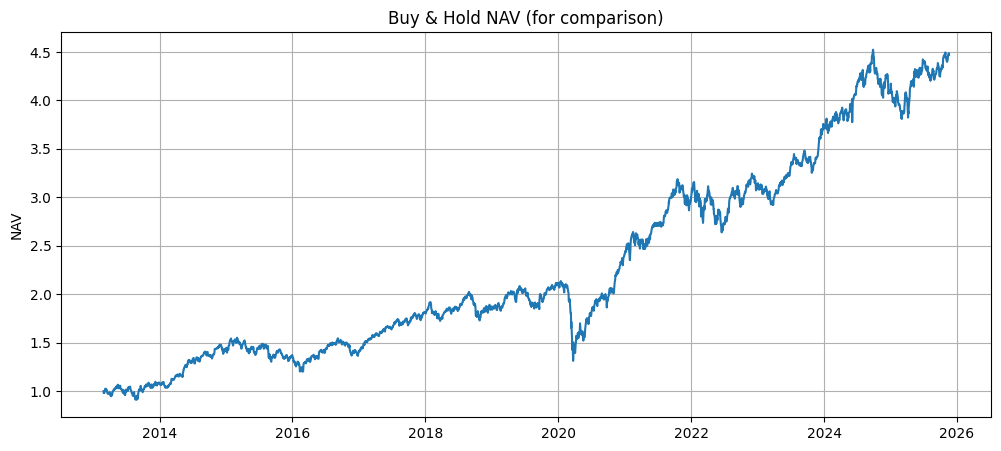

In [42]:
# ===== MASTER STRATEGY v5 (Balanced professional) =====
import numpy as np
import pandas as pd

# base copy from previous master (safe)
mv5 = master.copy()

# --- 1) Transaction costs & slippage assumptions (per trade)
# realistic for Indian equities index-like trades: 0.03% per round-trip (3 bps)
# We'll model cost as: cost_per_trade = 0.0003 (i.e., 0.03%) applied on entry day return
cost_per_roundtrip = 0.0003

# --- 2) Compute rolling vol (annualized) per regime (uses ret_close)
window_vol = 60  # trading days ~ 3 months
mv5['ret'] = mv5['ret_close']
mv5['rolling_vol'] = mv5['ret'].rolling(window_vol).std() * np.sqrt(252)
# fill small NaNs with global vol
global_vol = mv5['ret'].std() * np.sqrt(252)
mv5['rolling_vol'] = mv5['rolling_vol'].fillna(global_vol)

# --- 3) Per-regime baseline vol estimate (median during regime)
regime_vol = mv5.groupby('state_hmm')['rolling_vol'].median().to_dict()

# --- 4) Compute regime-adaptive target weight (risk parity-ish)
# idea: We want target risk contribution per trade to be similar across regimes.
# Choose a base risk target per trade (fractional vol)
base_target_vol = 0.06  # target annualized vol contribution per active position (6%)

def regime_target_weight(row):
    s = int(row['state_hmm'])
    regime_median_vol = regime_vol.get(s, global_vol)
    # weight scales so that weight * regime_vol ≈ base_target_vol
    # => weight = base_target_vol / regime_median_vol
    # cap weight to reasonable bounds [0.3, 2.0] to avoid extremes
    w = base_target_vol / (regime_median_vol + 1e-12)
    return float(np.clip(w, 0.3, 2.0))

mv5['regime_target_weight'] = mv5.apply(regime_target_weight, axis=1)

# --- 5) Combine with previous regime confidence weight (the earlier weights)
# earlier we used weights = {0:1.5, 1:1.0, 2:0.7}; keep that as a multiplier
base_weights_old = {0:1.5, 1:1.0, 2:0.7}
mv5['old_weight'] = mv5['state_hmm'].map(base_weights_old).fillna(1.0)

# final size = regime_target_weight * old_weight, capped to 2.5
mv5['size_unclipped'] = mv5['regime_target_weight'] * mv5['old_weight']
mv5['size'] = mv5['size_unclipped'].clip(lower=0.25, upper=2.5)

# --- 6) Final position: use master final_pos (binary) but weighted by size
# use lagged final_pos to avoid lookahead (we already used final_pos_lag earlier)
mv5['pos_lag'] = mv5['final_pos_lag']  # already shift(1)
mv5['weighted_pos'] = mv5['pos_lag'] * mv5['size']

# --- 7) Apply transaction costs on entries: detect entries and subtract cost from next-day return
entries = (mv5['final_pos'].diff() == 1).astype(int)  # 1 on entry day
mv5['entry_flag'] = entries
# cost applied on the day we enter (we model as an immediate hit to strategy return)
# since our strategy return uses pos_lag * ret_close, cost should be subtracted from ret on entry day+1 when pos_lag=1.
# We'll create a cost series shifted by +1
mv5['trade_cost'] = 0.0
mv5.loc[mv5.index, 'trade_cost'] = 0.0
mv5['trade_cost'] = entries.shift(1).fillna(0) * cost_per_roundtrip  # cost applied on the first day of being invested

# --- 8) Final strategy returns with sizing and costs
mv5['strat_ret_v5_raw'] = mv5['weighted_pos'] * mv5['ret']  # position scaled by size
mv5['strat_ret_v5'] = mv5['strat_ret_v5_raw'] - mv5['trade_cost']

# --- 9) NAV and metrics
mv5['nav_v5'] = (1 + mv5['strat_ret_v5']).cumprod()
metrics_v5 = compute_performance(mv5['nav_v5'])

print("=== MASTER STRATEGY v5 (Balanced) METRICS ===")
for k,v in metrics_v5.items():
    print(k, ":", round(v,6))

# exposure and entries
exp_v5 = mv5['pos_lag'].mean()
entries_v5 = int(entries.sum())
print("\nExposure (days invested):", round(exp_v5,4))
print("Number of entries (total):", entries_v5)

# --- 10) Regime contribution diagnostics (vol and returns share)
diag = []
for s in sorted(mv5['state_hmm'].unique()):
    mask = mv5['state_hmm'] == s
    sub = mv5[mask]
    if sub.empty:
        continue
    ret_sum = (sub['strat_ret_v5']).sum()
    vol = (sub['strat_ret_v5']).std() * np.sqrt(252)
    days_pct = len(sub) / len(mv5)
    diag.append((s, round(ret_sum,6), round(vol,6), round(days_pct,4), int((sub['pos_lag']==1).sum())))

diag_df = pd.DataFrame(diag, columns=['state','sum_ret','ann_vol','days_frac','days_invested'])
print("\nRegime diagnostics (state | total return contribution | ann vol | fraction of days | days invested):")
print(diag_df.to_string(index=False))

# --- 11) Plot NAVs
plot_nav(mv5['nav_v5'], title="MASTER STRATEGY v5 NAV (Balanced)")
plot_nav(mv5['nav_bnh'], title="Buy & Hold NAV (for comparison)")

# Expose mv5 for later
master_v5 = mv5.copy()